In [73]:
from layer import Dense, Dropout, Conv2d, Flatten, MaxPool2d
from activation import LeakyReLU
from solver import SGD
from loss import CrossEntropyLoss
from data import Dataset
from network import Network

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise

np.random.seed(42)

In [74]:
def evaluate_classification(y_true, y_pred):
    y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
    labels = range(0,10)
    
    # classification report
    print(classification_report(y_true, y_pred, digits=4))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize="true")  # row-normalized
    
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

In [75]:
def plot_hist(history):
    fig, ax = plt.subplots(1,2, figsize=(14,6))
    epochs = range(1, len(history['loss'])+1)

    # plot loss
    ax[0].plot(epochs, history['loss'], label='Training loss')
    if history['val_loss']:
        ax[0].plot(epochs, history['val_loss'], label='Validation loss')
    ax[0].set_title('Loss')
    ax[0].legend()

    # plot acc
    ax[1].plot(epochs, history['acc'], label='Training accuracy')
    if history['val_acc']:
        ax[1].plot(epochs, history['val_acc'], label='Validation accuracy')
    ax[1].set_title('Accuracy')
    ax[1].legend()

    plt.show()

In [76]:
def show_grid(X, y):
    # idx = np.random.choice(len(X), 9, replace=False)
    idx = range(len(X))
    images = X[idx]
    labels = np.argmax(y[idx], axis=1)

    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        img = images[i]

        if img.shape[0] == 1:   # grayscale (C=1)
            img = img[0]        # (H, W)
            ax.imshow(img, cmap="grey")
        else:                   # RGB or multi-channel
            img = np.transpose(img, (1, 2, 0))  # (H, W, C)
            ax.imshow(img)

        ax.set_title(str(labels[i]))
        ax.axis("off")

    plt.tight_layout()
    plt.show()


In [77]:
def transform_mnist(img):
    # random small rotation (-15° to +15°)
    angle = np.random.uniform(-15, 15)
    img = rotate(img, angle, mode="edge")

    # random shift & scale
    tform = AffineTransform(
        # shift up to 2 pixels
        translation=(np.random.uniform(-2, 2), np.random.uniform(-2, 2)),
        # +/- 10% zoom
        scale=(np.random.uniform(0.9, 1.1), np.random.uniform(0.9, 1.1))
    )
    img = warp(img, tform.inverse, mode="edge")

    # add random noise (40% chance)
    if np.random.random() < 0.4:
        img = random_noise(img, mode="gaussian", rng=42, var=0.01)

    return img.astype(np.float32)

def transform_mnist_dataset(X):
    batch, channel, H, W = X.shape
    X_aug = np.empty_like(X, dtype=np.float32)  # preallocate output

    for i in range(batch):
        # If single channel, we can just pass X[i,0]; if multi-channel, could loop over channels
        X_aug[i, 0] = transform_mnist(X[i, 0])

    return X_aug

# MNIST

### Load MNIST

In [78]:
# load mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### X transform

In [79]:
# data preproccess
X_train = X_train.astype('float32')   
X_test = X_test.astype('float32')

# get values from 0 to 1
X_train /= 255                        
X_test /= 255

# reshape so that it has 1 channel
X_train = X_train.reshape(60000, 1, 28, 28)
X_test = X_test.reshape(10000, 1, 28, 28)

In [80]:
# create validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

### Class balance

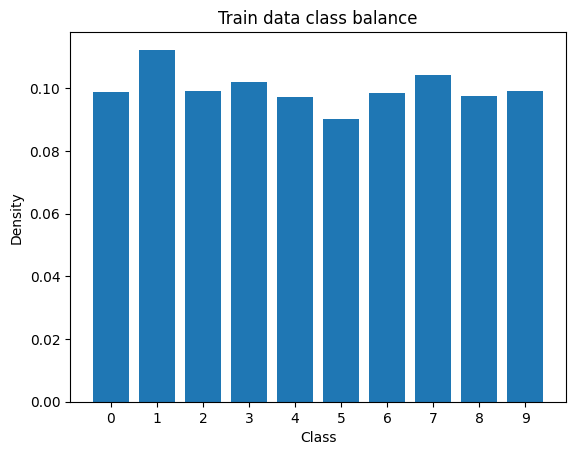

In [81]:
classes = range(0,10)

plt.bar(classes, np.bincount(y_train)/len(y_train))
plt.xticks(classes)
plt.xlabel('Class')
plt.ylabel('Density')
plt.title('Train data class balance')
plt.show()

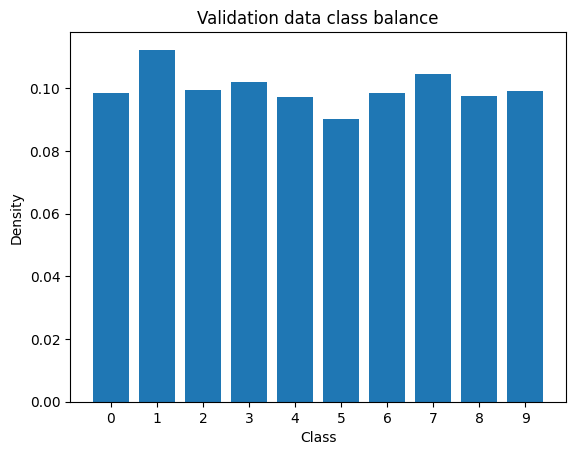

In [82]:
plt.bar(classes, np.bincount(y_val)/len(y_val))
plt.xticks(classes)
plt.xlabel('Class')
plt.ylabel('Density')
plt.title('Validation data class balance')
plt.show()

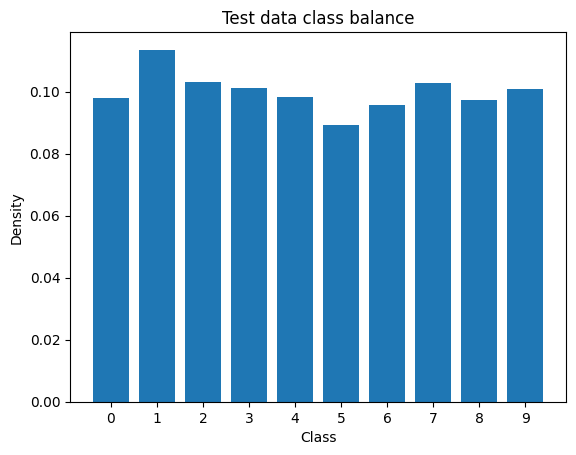

In [83]:
plt.bar(classes, np.bincount(y_test)/len(y_test))
plt.xticks(classes)
plt.xlabel('Class')
plt.ylabel('Density')
plt.title('Test data class balance')
plt.show()

### Y transform

In [84]:
no_classes = 10
y_train = np.eye(no_classes)[y_train]
y_val = np.eye(no_classes)[y_val]
y_test = np.eye(no_classes)[y_test]

In [85]:
train_data = Dataset(X_train, y_train)
val_data = Dataset(X_val, y_val)
test_data = Dataset(X_test, y_test)

### CNN

In [86]:
mnist_cnn = Network([
    Conv2d(1, 16, 3, padding=1),  # 16 x 28 x 28
    LeakyReLU(0.1), 
    MaxPool2d(),                  # 16 x 14 x 14

    Conv2d(16, 32, 3, padding=1), # 32 x 14 x 14
    LeakyReLU(0.1), 
    MaxPool2d(),                  # 32 x 7 x 7

    Flatten(),                    # 32*7*7 -> 1568
    
    Dense(128),
    LeakyReLU(0.1),

    Dense(10),
])

In [87]:
solver = SGD(lr=0.1)
loss = CrossEntropyLoss()

In [88]:
mnist_cnn.compile(loss=loss, solver=solver)

In [89]:
early_stopping={
    'patience': 5,
    'min_delta': 0,
    'restore_best_parameters': True
}

### CNN

In [90]:
try:
    mnist_cnn = joblib.load('mnist_cnn_1.joblib')
except:
    history = mnist_cnn.train(dataset=train_data, epochs=10, val_dataset=val_data, early_stopping=early_stopping)
    # save the model
    joblib.dump(mnist_cnn, 'mnist_cnn_1.joblib')

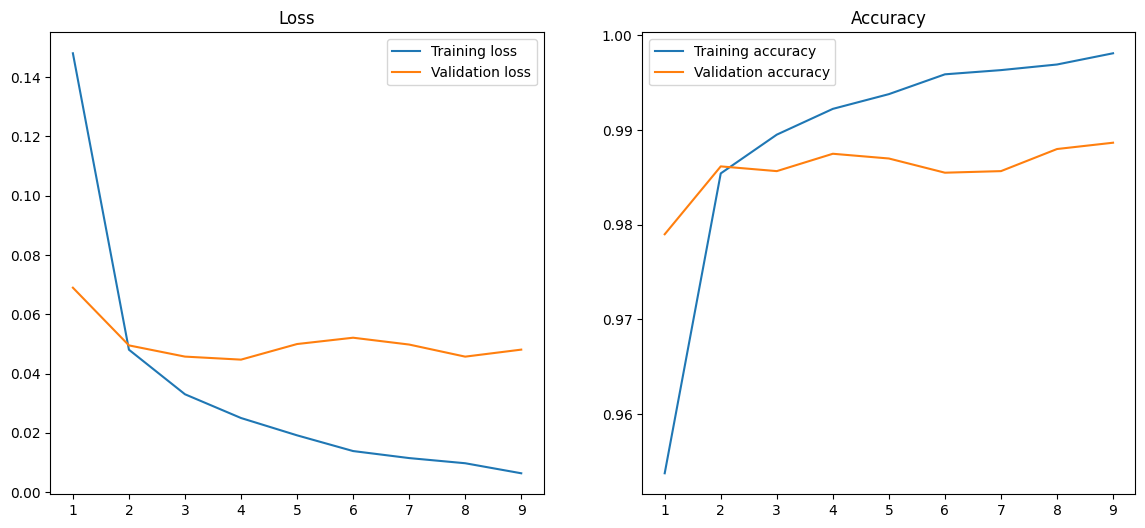

In [91]:
plot_hist(mnist_cnn.history)

early stopping triggered at epoch 9, params reverted to epoch 4

In [92]:
y_pred = mnist_cnn.predict(X_test)

In [93]:
accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

0.9896

              precision    recall  f1-score   support

           0     0.9939    0.9949    0.9944       980
           1     0.9956    0.9956    0.9956      1135
           2     0.9941    0.9845    0.9893      1032
           3     0.9805    0.9950    0.9877      1010
           4     0.9939    0.9908    0.9924       982
           5     0.9833    0.9922    0.9877       892
           6     0.9958    0.9823    0.9890       958
           7     0.9836    0.9903    0.9869      1028
           8     0.9857    0.9918    0.9887       974
           9     0.9890    0.9782    0.9836      1009

    accuracy                         0.9896     10000
   macro avg     0.9895    0.9896    0.9895     10000
weighted avg     0.9896    0.9896    0.9896     10000



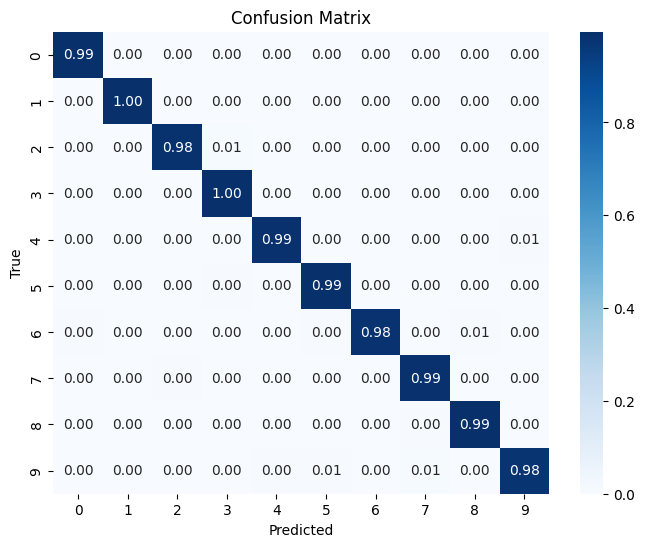

In [94]:
evaluate_classification(y_test, y_pred)

### Dense NN

In [95]:
mnist_nn = Network([
    Flatten(),                    # 28*28 -> 784
    
    Dense(128),
    LeakyReLU(0.1),

    Dense(128),
    LeakyReLU(0.1),

    Dense(10),
])

mnist_nn.compile(loss, solver)

In [96]:
try:
    mnist_nn = joblib.load('mnist_nn_1.joblib')
except:
    history = mnist_nn.train(dataset=train_data, epochs=20, val_dataset=val_data, early_stopping=early_stopping)
    # save the model
    joblib.dump(mnist_nn, 'mnist_nn_1.joblib')

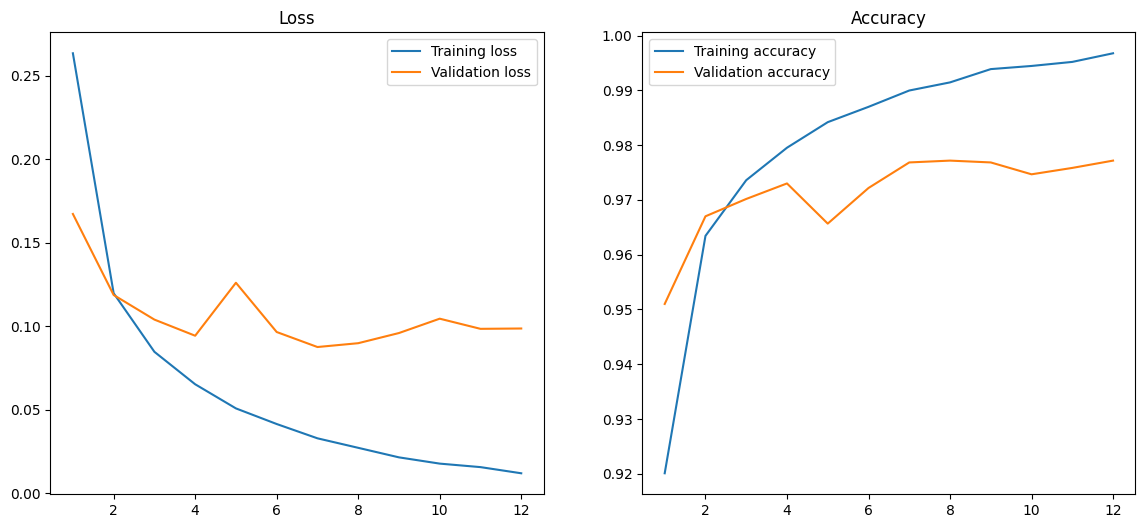

In [97]:
plot_hist(mnist_nn.history)

early stopping triggered at epoch 12, params reverted to epoch 7

In [98]:
y_pred = mnist_nn.predict(X_test)
accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

0.9779

              precision    recall  f1-score   support

           0     0.9807    0.9847    0.9827       980
           1     0.9878    0.9956    0.9917      1135
           2     0.9787    0.9777    0.9782      1032
           3     0.9848    0.9634    0.9740      1010
           4     0.9877    0.9837    0.9857       982
           5     0.9648    0.9821    0.9733       892
           6     0.9742    0.9854    0.9798       958
           7     0.9879    0.9553    0.9713      1028
           8     0.9813    0.9692    0.9752       974
           9     0.9501    0.9812    0.9654      1009

    accuracy                         0.9779     10000
   macro avg     0.9778    0.9778    0.9777     10000
weighted avg     0.9781    0.9779    0.9779     10000



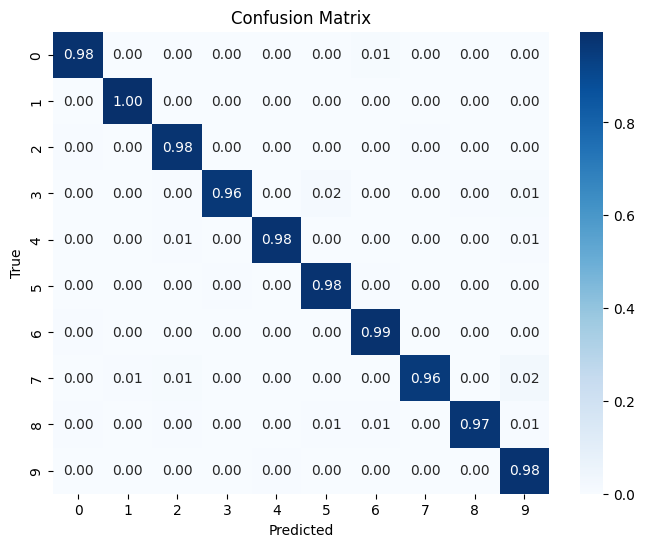

In [99]:
evaluate_classification(y_test, y_pred)

# Transform MNIST

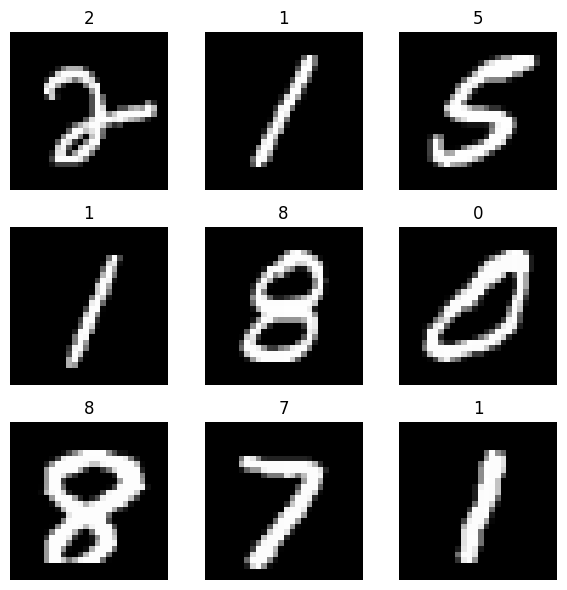

In [100]:
show_grid(X_train[:9], y_train[:9])

In [101]:
X_train_trans = transform_mnist_dataset(X_train)

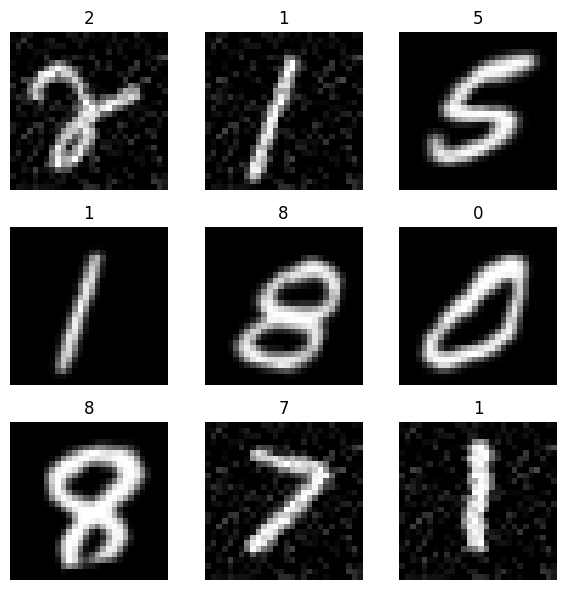

In [102]:
show_grid(X_train_trans[:9], y_train[:9])

In [103]:
train_data_trans = Dataset(X_train_trans, y_train)

### Dense NN

In [104]:
mnist_nn_2 = Network([
    Flatten(),                    # 28*28 -> 784
    
    Dense(128),
    LeakyReLU(0.1),
    Dropout(0.3),

    Dense(128),
    LeakyReLU(0.1),
    Dropout(0.3),

    Dense(10),
])

mnist_nn_2.compile(loss, solver)

In [105]:
early_stopping['patience'] = 10 

In [106]:
try:
    mnist_nn_2 = joblib.load('mnist_nn_2.joblib')
except:
    history = mnist_nn_2.train(dataset=train_data_trans, epochs=50, val_dataset=val_data, early_stopping=early_stopping)
    # save the model
    joblib.dump(mnist_nn_2, 'mnist_nn_2.joblib')

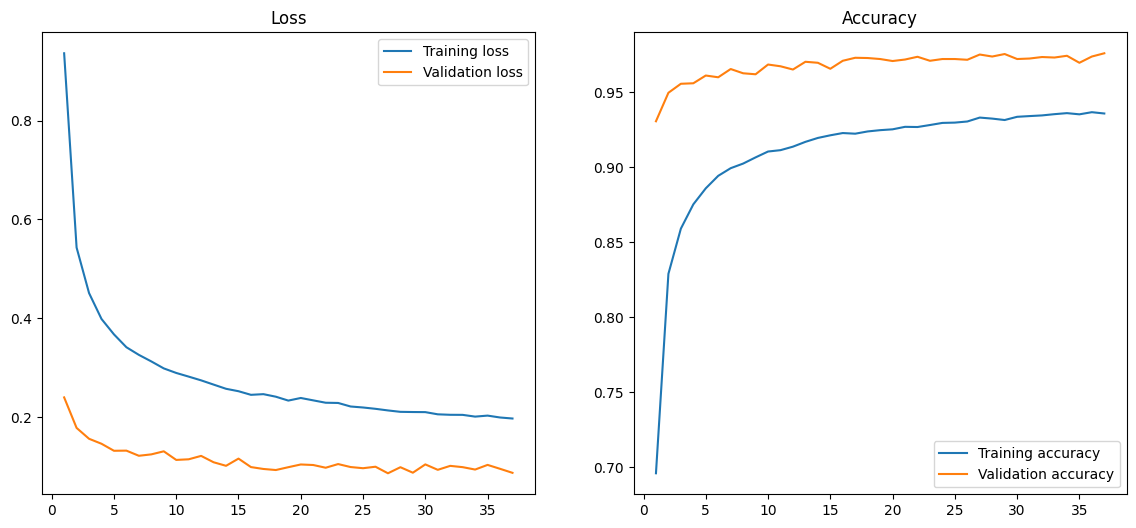

In [107]:
plot_hist(mnist_nn_2.history)

In [113]:
mnist_nn_2.early_stopped

{'epoch_stopped': 37, 'epoch_params': 27}

In [108]:
y_pred = mnist_nn_2.predict(X_test)
accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

0.9788

              precision    recall  f1-score   support

           0     0.9818    0.9918    0.9868       980
           1     0.9921    0.9921    0.9921      1135
           2     0.9751    0.9855    0.9802      1032
           3     0.9762    0.9752    0.9757      1010
           4     0.9855    0.9705    0.9779       982
           5     0.9701    0.9821    0.9760       892
           6     0.9884    0.9791    0.9837       958
           7     0.9693    0.9844    0.9768      1028
           8     0.9841    0.9528    0.9682       974
           9     0.9646    0.9722    0.9684      1009

    accuracy                         0.9788     10000
   macro avg     0.9787    0.9786    0.9786     10000
weighted avg     0.9789    0.9788    0.9788     10000



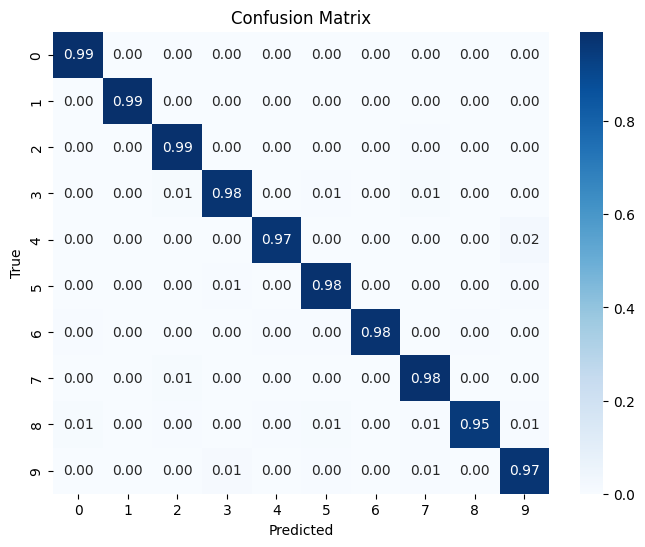

In [109]:
evaluate_classification(y_test, y_pred)

### CNN

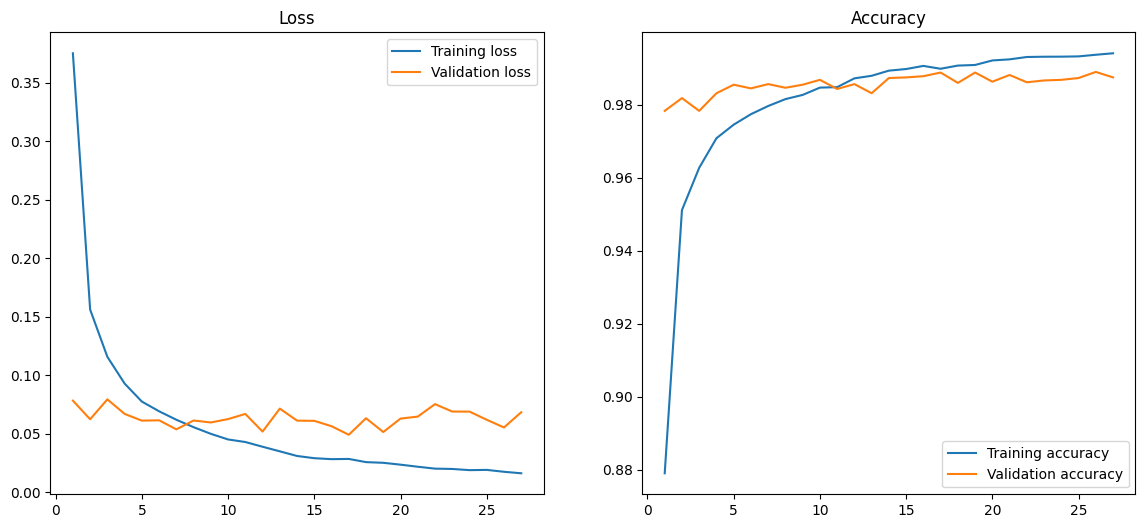

In [110]:
mnist_cnn_2 = Network([
    Conv2d(1, 16, 3, padding=1),  # 16 x 28 x 28
    LeakyReLU(0.1), 
    MaxPool2d(),                  # 16 x 14 x 14

    Conv2d(16, 32, 3, padding=1), # 32 x 14 x 14
    LeakyReLU(0.1), 
    MaxPool2d(),                  # 32 x 7 x 7

    Flatten(),                    # 32*7*7 -> 1568
    
    Dense(128),
    LeakyReLU(0.1),
    Dropout(0.3),

    Dense(10),
])

mnist_cnn_2.compile(loss, solver)

try:
    mnist_cnn_2 = joblib.load('mnist_cnn_2.joblib')
except:
    history = mnist_cnn_2.train(dataset=train_data_trans, epochs=50, val_dataset=val_data, early_stopping=early_stopping)
    # save the model
    joblib.dump(mnist_cnn_2, 'mnist_cnn_2.joblib')

plot_hist(mnist_cnn_2.history)

In [114]:
mnist_cnn_2.early_stopped

{'epoch_stopped': 27, 'epoch_params': 17}

In [111]:
y_pred = mnist_cnn_2.predict(X_test)
accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

0.9914

              precision    recall  f1-score   support

           0     0.9929    0.9959    0.9944       980
           1     0.9973    0.9921    0.9947      1135
           2     0.9932    0.9913    0.9922      1032
           3     0.9911    0.9921    0.9916      1010
           4     0.9959    0.9929    0.9944       982
           5     0.9822    0.9899    0.9860       892
           6     0.9968    0.9906    0.9937       958
           7     0.9893    0.9893    0.9893      1028
           8     0.9867    0.9918    0.9892       974
           9     0.9871    0.9881    0.9876      1009

    accuracy                         0.9914     10000
   macro avg     0.9913    0.9914    0.9913     10000
weighted avg     0.9914    0.9914    0.9914     10000



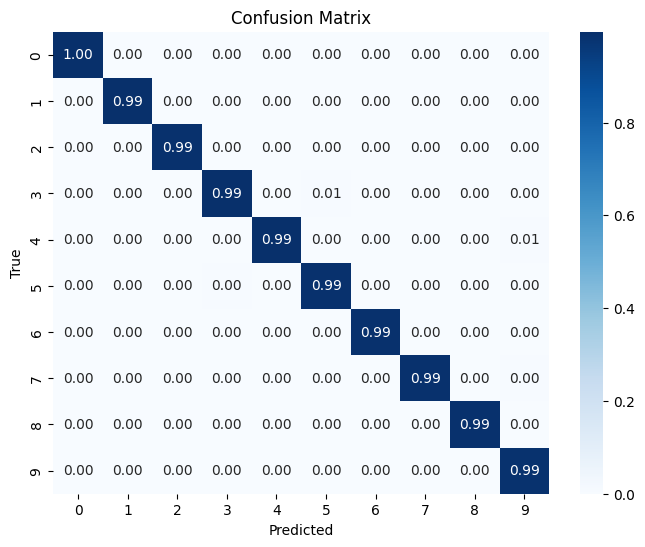

In [112]:
evaluate_classification(y_test, y_pred)